### 1.1 Import library

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.preprocessing import LabelBinarizer,PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.model_selection import KFold
import lightgbm as lgb
%matplotlib inline
plt.style.use('ggplot')
seed =420

### 1.2 Load dataset

In [142]:
nrows = 1000
#nrows =None
#path = '../input/'
path = 'dataset/'
app_train = pd.read_csv(path+'application_train.csv', nrows= nrows)
app_test = pd.read_csv(path+'application_test.csv', nrows= None)
bureau_balance = pd.read_csv(path+'bureau_balance.csv', nrows=nrows)
bureau = pd.read_csv(path+'bureau.csv', nrows=nrows)
credit_card_balance = pd.read_csv(path+'credit_card_balance.csv',nrows=nrows)
installments_payments = pd.read_csv(path+ 'installments_payments.csv', nrows= nrows)
POS_CASH_balance = pd.read_csv(path+ 'POS_CASH_balance.csv', nrows= nrows)
previous_application = pd.read_csv(path+ 'previous_application.csv', nrows= nrows)
gc.collect()

test_index = app_test['SK_ID_CURR']

### 1.3 Reduce memory of dataset function

In [143]:
# Reduce memory of dataset
def reduce_memory_usage(df):
    """ The function will reduce memory of dataframe
    Note: Apply this function after removing missing value"""
    intial_memory = df.memory_usage().sum()/1024**2
    print('Intial memory usage:',intial_memory,'MB')
    for col in df.columns:
        mn = df[col].min()
        mx = df[col].max()
        if df[col].dtype != object:            
            if df[col].dtype == int:
                if mn >=0:
                    if mx < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif mx < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            if df[col].dtype == float:
                df[col] =df[col].astype(np.float32)
    
    red_memory = df.memory_usage().sum()/1024**2
    print('Memory usage after complition: ',red_memory,'MB')

### 1.4 Basic details function

In [144]:
def basic_details(df):
    k = pd.DataFrame()
    k['missing_value'] = df.isnull().sum()
    k['%missing_value'] = round(df.isnull().sum()*100/df.shape[0],2)
    k['dtypes'] = df.dtypes
    k['N unique'] = df.nunique()
    #k['mean'] = df.mean()
    return k

### 1.5 Fill missing value function

In [145]:
# Fill missing value with mode
def missing_value_fill(df ,columns, mean_or_mode='mode'):
    for i in columns:
        if (df[i].isnull().sum()>0) and (mean_or_mode =='mode'):
            df[i].fillna(df[i].mode()[0], inplace=True)
        elif (df[i].isnull().sum()>0) and (mean_or_mode =='mean'):
            df[i].fillna(df[i].mean(), inplace=True)

### 1.6 One hot encoding function

In [146]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [147]:
def one_hot_encoding(df,columns):
    print('Original shape',df.shape)
    original_columns = df.columns
    # One hot encoding using get dummies function
    df = pd.get_dummies(df, columns= columns,drop_first=True,dummy_na=True)
    new_columns = [i for i in df.columns if i not in original_columns]
    print('After OHE',df.shape)
    return df,new_columns

In [148]:
def descriptive_stat_feat(df,columns):
    """ Descriptive statistics feature
    genarating function: Mean,Median,Q1,Q3"""
    print('Before',df.shape)
    mean = df[columns].mean()
    median = df[columns].median()
    Q1 = np.quantile(df[columns], 0.25, axis=0)
    Q3 = np.quantile(df[columns], 0.75, axis=0)
    for i,j in enumerate(columns):
        df['mean_'+j] = (df[j] < mean[i]).astype('int8')
        df['median_'+j] = (df[j] > median[i]).astype('int8')
        df['Q1'+j] = (df[j] < Q1[i]).astype('int8')
        df['Q3'+j] = (df[j] > Q3[i]).astype('int8')
    print('After ',df.shape)

In [149]:
def binary_encoding(df,columns):
    """Binary encoding"""
    lb = LabelBinarizer()
    print('Original shape:',df.shape)
    #columns = [i for i in columns if df[columns].nunique()>2]
    for i in columns:
        if df[i].nunique() >2:
            result = lb.fit_transform(df[i].fillna(df[i].mode()[0],axis=0))
            col = ['Bin_'+ i+'_'+c for c in lb.classes_]
            result1 = pd.DataFrame(result, columns=col)
            df = df.join(result1)
    print('After:',df.shape)
    return df

## 2 Application train/test dataset
### 2.0 Glimpse Application train / test dataset

In [150]:
print('Number of rows and columns in train dataset: ',app_train.shape)
app_train.head()

Number of rows and columns in train dataset:  (1000, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
print('Number of rows and columns in test dataset: ',app_test.shape)
app_test.head()

Number of rows and columns in test dataset:  (1000, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
pd.read_csv(path+'sample_submission.csv').head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


### 2.1 Exploratory data analysis of application train

In [153]:
app_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

### 2.2 Current id

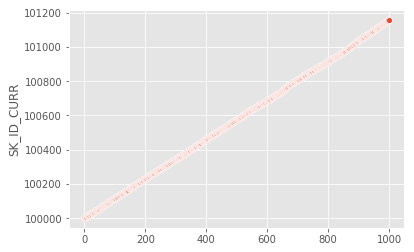

In [154]:
sns.scatterplot(range(app_train.shape[0]),app_train['SK_ID_CURR'].sort_values())

### 2.3 Target

In [155]:
test_index = app_test['SK_ID_CURR']

In [156]:
print('Count\n',app_train['TARGET'].value_counts())
print('%\n',app_train['TARGET'].value_counts()*100/app_train.shape[0])

Count
 0    930
1     70
Name: TARGET, dtype: int64
%
 0    93.0
1     7.0
Name: TARGET, dtype: float64


The 0 stands for loan repayment on time, 1 stands for loan repayment not done on time, so only 7% of loan repayment happens late.

### 2.4 Binary feature

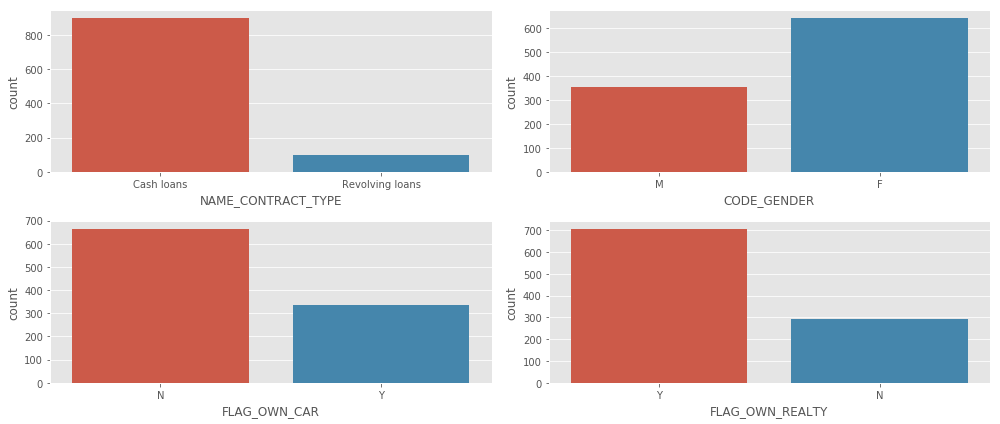

In [157]:
f =plt.figure(figsize=(14,6))
ax= f.add_subplot(221)
sns.countplot(app_train['NAME_CONTRACT_TYPE'])
ax=f.add_subplot(222)
sns.countplot(app_train['CODE_GENDER'])
ax=f.add_subplot(223)
sns.countplot(app_train['FLAG_OWN_CAR'])
ax=f.add_subplot(224)
sns.countplot(app_train['FLAG_OWN_REALTY'])
plt.tight_layout()

### 2.5 Number of Children

In [158]:
#sns.countplot(app_train['CNT_CHILDREN'])pd.plot()
tmp = app_train['CNT_CHILDREN'].value_counts().to_frame()
tmp['%'] = (app_train['CNT_CHILDREN'].value_counts() *100 / app_train.shape[0])
tmp

,CNT_CHILDREN,%
0,715,71.5
1,177,17.7
2,95,9.5
3,13,1.3


### 2.6 Total income amount

/home/sudhir/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


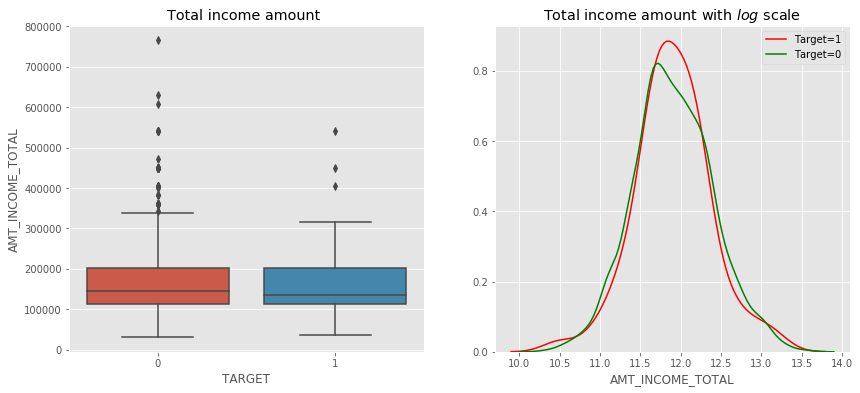

In [159]:
# Apply natural log on total income
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.boxplot(x ='TARGET', y='AMT_INCOME_TOTAL', data=app_train,ax=ax)
ax.set_title('Total income amount ')
ax = f.add_subplot(122)
sns.distplot(np.log(app_train[app_train['TARGET']==1]['AMT_INCOME_TOTAL'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot(np.log(app_train[app_train['TARGET']==0]['AMT_INCOME_TOTAL'])
             ,ax=ax,color='green',label='Target=0',hist=False)
ax.set_title('Total income amount with $log$ scale')
plt.legend()

Their are many high income peolple's loans are not payed in time 

### 2.7 Credit amount

/home/sudhir/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


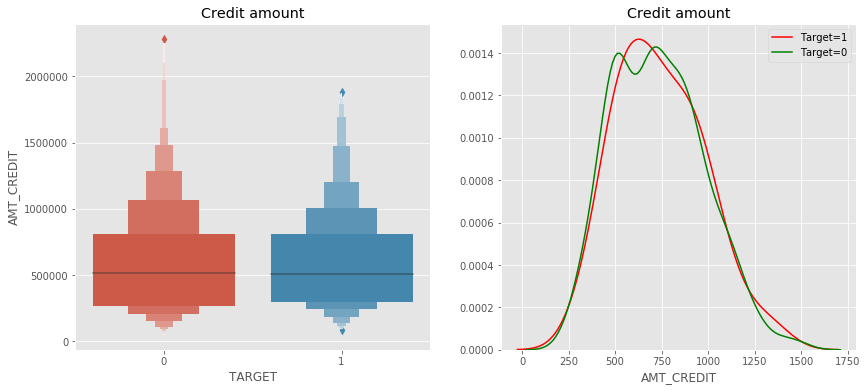

In [160]:
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.boxenplot(x ='TARGET', y='AMT_CREDIT', data=app_train,ax=ax)
ax.set_title('Credit amount')
ax = f.add_subplot(122)
sns.distplot(np.sqrt(app_train[app_train['TARGET']==1]['AMT_CREDIT'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot(np.sqrt(app_train[app_train['TARGET']==0]['AMT_CREDIT'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax.set_title('Credit amount')
plt.legend()

### 2.8 Annuity amount

/home/sudhir/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


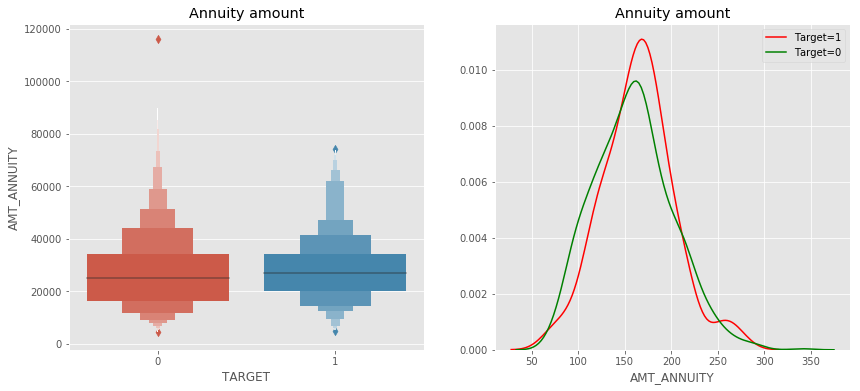

In [161]:
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.boxenplot(x ='TARGET', y='AMT_ANNUITY', data=app_train,ax=ax)
ax.set_title('Annuity amount')
ax = f.add_subplot(122)
sns.distplot(np.sqrt(app_train[app_train['TARGET']==1]['AMT_ANNUITY'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot(np.sqrt(app_train[app_train['TARGET']==0]['AMT_ANNUITY'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax.set_title('Annuity amount')
plt.legend()

### 2.9 Goods price amount

/home/sudhir/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


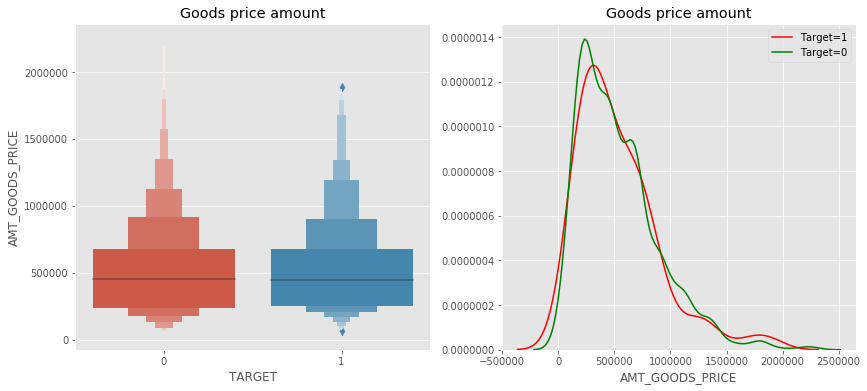

In [162]:
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.boxenplot(x ='TARGET', y='AMT_GOODS_PRICE', data=app_train,ax=ax)
ax.set_title('Goods price amount')
ax = f.add_subplot(122)
sns.distplot((app_train[app_train['TARGET']==1]['AMT_GOODS_PRICE'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot((app_train[app_train['TARGET']==0]['AMT_GOODS_PRICE'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax.set_title('Goods price amount')
plt.legend()

### 2.10 Personal information

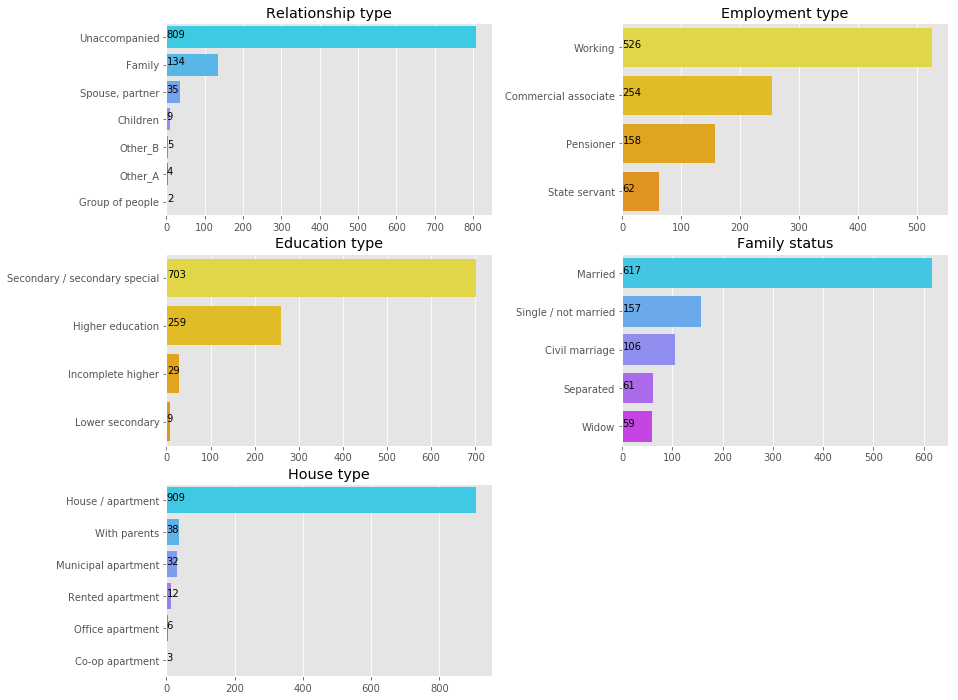

In [163]:
f = plt.figure(figsize= (14,12))
#plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))

ax= f.add_subplot(321)
tmp = app_train['NAME_TYPE_SUITE'].value_counts()
sns.barplot(tmp.values,tmp.index,palette='cool')
for i, v in enumerate(tmp.values):
    ax.text(0.8,i,v,color='k',fontsize=10)
ax.set_title('Relationship type')

ax = f.add_subplot(322)
tmp = app_train['NAME_INCOME_TYPE'].value_counts()
sns.barplot(tmp.values,tmp.index,palette='Wistia')
for i, v in enumerate(tmp.values):
    ax.text(0.8,i,v,color='k',fontsize=10)
ax.set_title('Employment type')

ax = f.add_subplot(323)
tmp = app_train['NAME_EDUCATION_TYPE'].value_counts()
sns.barplot(tmp.values,tmp.index,palette='Wistia')
for i, v in enumerate(tmp.values):
    ax.text(0.8,i,v,color='k',fontsize=10)
ax.set_title('Education type')

ax = f.add_subplot(324)
tmp = app_train['NAME_FAMILY_STATUS'].value_counts()
sns.barplot(tmp.values,tmp.index,palette='cool')
for i, v in enumerate(tmp.values):
    ax.text(0.8,i,v,color='k',fontsize=10)
ax.set_title('Family status')

ax = f.add_subplot(325)
tmp = app_train['NAME_HOUSING_TYPE'].value_counts()
sns.barplot(tmp.values,tmp.index,palette='cool')
for i, v in enumerate(tmp.values):
    ax.text(0.8,i,v,color='k',fontsize=10)
ax.set_title('House type')

plt.subplots_adjust(wspace=0.4)

### 2.11 Region population

/home/sudhir/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


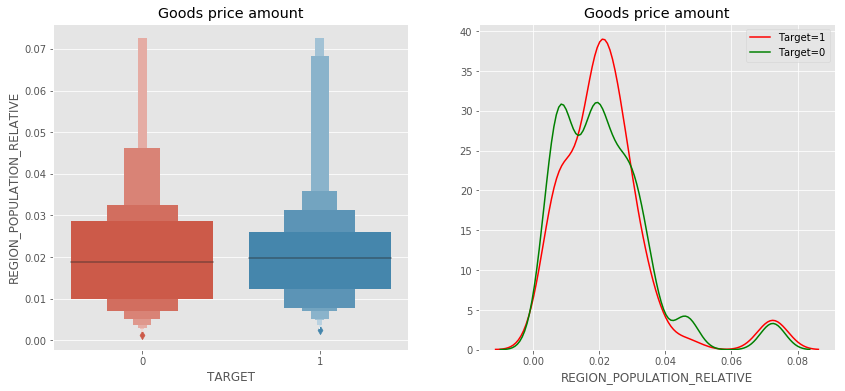

In [164]:
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.boxenplot(x ='TARGET', y='REGION_POPULATION_RELATIVE', data=app_train,ax=ax)
ax.set_title('Goods price amount')
ax = f.add_subplot(122)
sns.distplot((app_train[app_train['TARGET']==1]['REGION_POPULATION_RELATIVE'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot((app_train[app_train['TARGET']==0]['REGION_POPULATION_RELATIVE'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax.set_title('Goods price amount')
plt.legend();

### 2.12 Birth days

In [165]:
(app_train['DAYS_BIRTH']/-365).describe()

count    1000.000000
mean       43.486981
std        11.605080
min        21.109589
25%        33.771233
50%        43.131507
75%        52.682192
max        68.778082
Name: DAYS_BIRTH, dtype: float64

/home/sudhir/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Age in years')

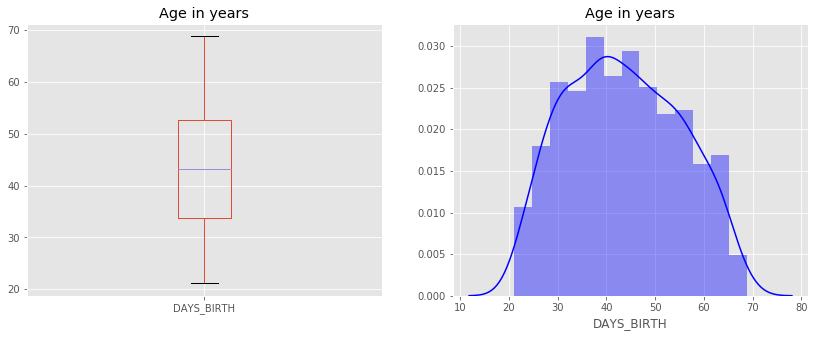

In [166]:
f = plt.figure(figsize= (14,5))
ax = f.add_subplot(121)
(app_train['DAYS_BIRTH']/-365).plot(kind='box',ax=ax)
ax.set_title('Age in years')
ax = f.add_subplot(122)
sns.distplot(app_train['DAYS_BIRTH']/-365,color='blue')
ax.set_title('Age in years')

### 2.13 Number of days employed

In [167]:
print('missing value:',app_train['DAYS_EMPLOYED'].isnull().sum())
(app_train['DAYS_EMPLOYED']/-365).describe()

missing value: 0


count    1000.000000
mean     -152.695633
std       367.559201
min     -1000.665753
25%         0.832877
50%         3.471233
75%         7.463014
max        42.827397
Name: DAYS_EMPLOYED, dtype: float64

In [168]:
((app_train['DAYS_EMPLOYED']/-365)[(app_train['DAYS_EMPLOYED']/-365)<0][:5],
app_train['DAYS_EMPLOYED'][app_train['DAYS_EMPLOYED']>0][:5],
app_test['DAYS_EMPLOYED'][app_test['DAYS_EMPLOYED']>0][:5])

(8    -1000.665753
 11   -1000.665753
 23   -1000.665753
 38   -1000.665753
 43   -1000.665753
 Name: DAYS_EMPLOYED, dtype: float64, 8     365243
 11    365243
 23    365243
 38    365243
 43    365243
 Name: DAYS_EMPLOYED, dtype: int64, 10    365243
 17    365243
 22    365243
 26    365243
 36    365243
 Name: DAYS_EMPLOYED, dtype: int64)

/home/sudhir/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Employed in years')

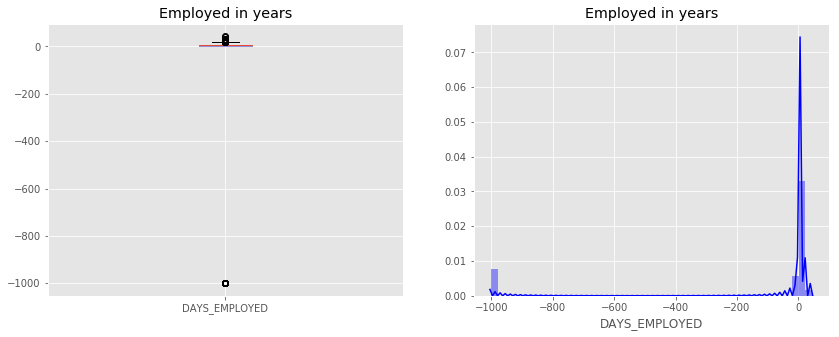

In [169]:
f = plt.figure(figsize= (14,5))
ax = f.add_subplot(121)
(app_train['DAYS_EMPLOYED']/-365).plot(kind='box',ax=ax)
ax.set_title('Employed in years')
ax = f.add_subplot(122)
sns.distplot((app_train['DAYS_EMPLOYED'].dropna()/-365),color='blue')
ax.set_title('Employed in years')

### 2.14 Redistration days

In [170]:
(app_train['DAYS_REGISTRATION']/-365).describe()

count    1000.000000
mean       13.389099
std         9.662337
min         0.008219
25%         5.113699
50%        12.335616
75%        19.790411
max        47.391781
Name: DAYS_REGISTRATION, dtype: float64

/home/sudhir/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Registration in years')

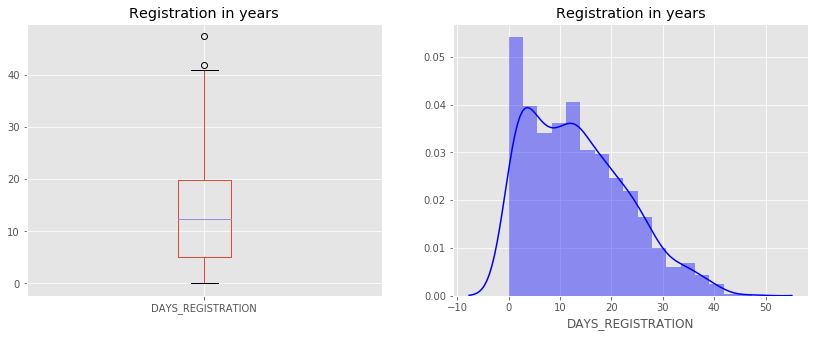

In [171]:
f = plt.figure(figsize= (14,5))
ax = f.add_subplot(121)
(app_train['DAYS_REGISTRATION']/-365).plot(kind='box',ax=ax)
ax.set_title('Registration in years')
ax = f.add_subplot(122)
sns.distplot((app_train['DAYS_REGISTRATION'].dropna()/-365),color='blue')
ax.set_title('Registration in years')

### 2.15 Publish id days

In [172]:
(app_train['DAYS_ID_PUBLISH']/-365).describe()

count    1000.000000
mean        8.041375
std         4.149993
min         0.002740
25%         4.388356
50%         8.668493
75%        11.663699
max        17.049315
Name: DAYS_ID_PUBLISH, dtype: float64

/home/sudhir/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Publish id in years')

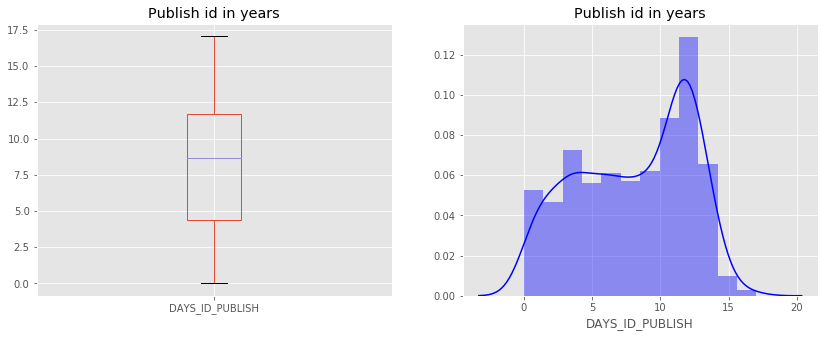

In [173]:
f = plt.figure(figsize= (14,5))
ax = f.add_subplot(121)
(app_train['DAYS_ID_PUBLISH']/-365).plot(kind='box',ax=ax)
ax.set_title('Publish id in years')
ax = f.add_subplot(122)
sns.distplot((app_train['DAYS_ID_PUBLISH'].dropna()/-365),color='blue')
ax.set_title('Publish id in years')

### 2.16 Own car age

In [174]:
app_train['OWN_CAR_AGE'].nunique()

32

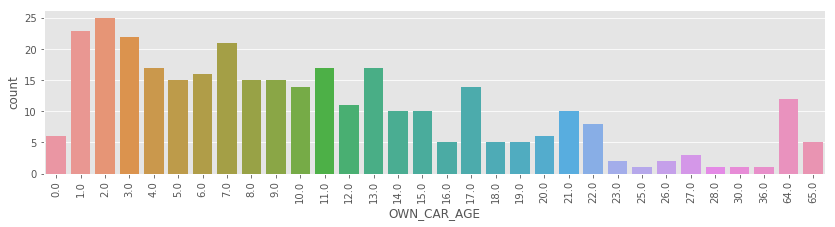

In [175]:
plt.figure(figsize= (14,3))
sns.countplot(app_train['OWN_CAR_AGE'])
#plt.title('Count plot of Own car age')
plt.xticks(rotation=90);

### 2.17 Communication availablity

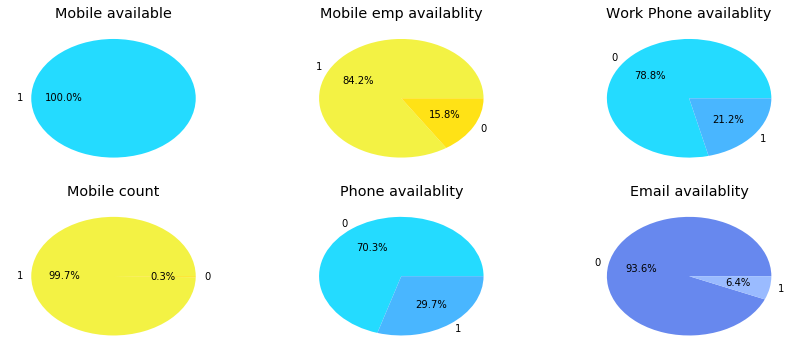

In [176]:
f = plt.figure(figsize= (14,6))

ax= f.add_subplot(231)
tmp = app_train['FLAG_MOBIL'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('Mobile available')

ax = f.add_subplot(232)
tmp = app_train['FLAG_EMP_PHONE'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('Wistia'))
ax.set_title('Mobile emp availablity')

ax = f.add_subplot(233)
tmp = app_train['FLAG_WORK_PHONE'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('Work Phone availablity')

ax = f.add_subplot(234)
tmp = app_train['FLAG_CONT_MOBILE'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('Wistia'))
ax.set_title('Mobile count')

ax = f.add_subplot(235)
tmp = app_train['FLAG_PHONE'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('Phone availablity')

ax = f.add_subplot(236)
tmp = app_train['FLAG_EMAIL'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('coolwarm'))
ax.set_title('Email availablity')

plt.subplots_adjust(wspace=0.4)

### 2.18 Farm members count

In [177]:
app_train['CNT_FAM_MEMBERS'].nunique()

5

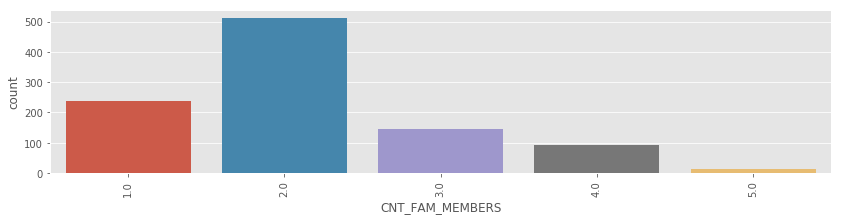

In [178]:
plt.figure(figsize= (14,3))
sns.countplot(app_train['CNT_FAM_MEMBERS'])
#plt.title('Count plot of Own car age')
plt.xticks(rotation=90);

### 2.19 Region rating client

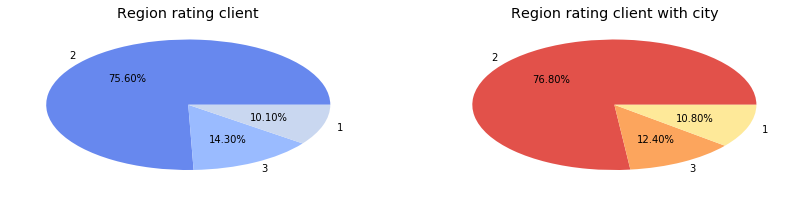

In [179]:
f = plt.figure(figsize= (14,3))

ax = f.add_subplot(121)
tmp = app_train['REGION_RATING_CLIENT'].value_counts()
ax.pie(tmp.values, labels= tmp.index, autopct= '%1.2f%%',colors=sns.color_palette('coolwarm'))
ax.set_title('Region rating client')

ax = f.add_subplot(122)
tmp = app_train['REGION_RATING_CLIENT_W_CITY'].value_counts()
ax.pie(tmp.values, labels= tmp.index, autopct= '%1.2f%%',colors=sns.color_palette('Spectral'))
ax.set_title('Region rating client with city');

### 2.20 Weekday appr process start

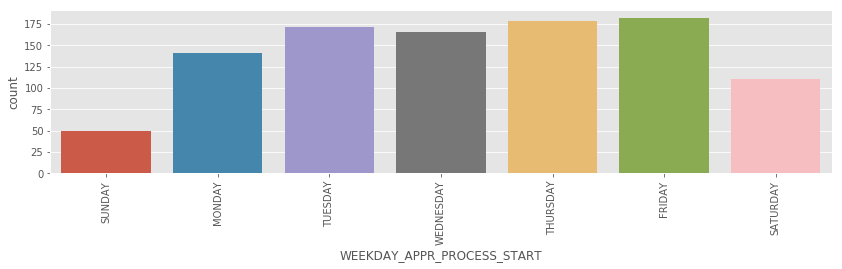

In [180]:
plt.figure(figsize= (14,3))
sns.countplot(app_train['WEEKDAY_APPR_PROCESS_START'],
              order=['SUNDAY','MONDAY','TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY','SATURDAY', ])
#plt.title('Count plot of Own car age')
plt.xticks(rotation=90);

### 2.21 Hour appr process start

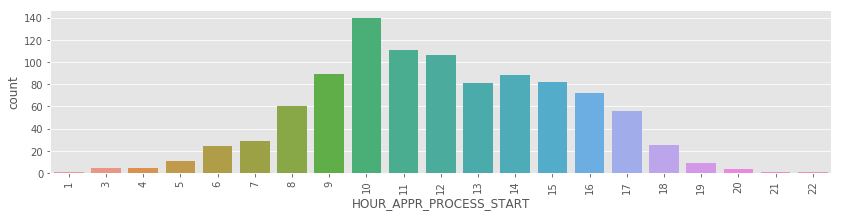

In [181]:
plt.figure(figsize= (14,3))
sns.countplot(app_train['HOUR_APPR_PROCESS_START'])
#plt.title('Count plot of Own car age')
plt.xticks(rotation=90);

### 2.22 Region type

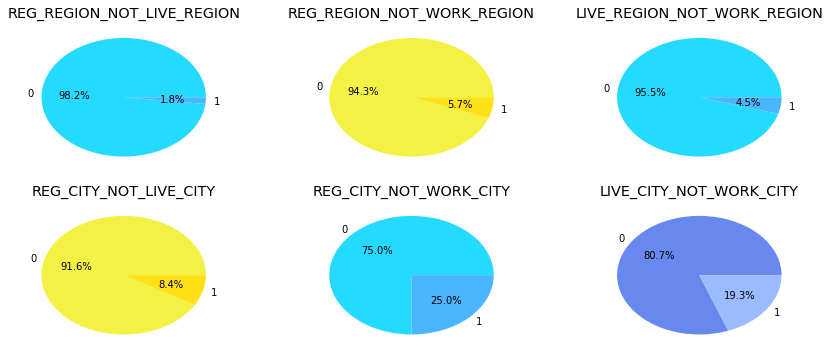

In [182]:
f = plt.figure(figsize= (14,6))

ax= f.add_subplot(231)
tmp = app_train['REG_REGION_NOT_LIVE_REGION'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('REG_REGION_NOT_LIVE_REGION')

ax = f.add_subplot(232)
tmp = app_train['REG_REGION_NOT_WORK_REGION'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('Wistia'))
ax.set_title('REG_REGION_NOT_WORK_REGION')

ax = f.add_subplot(233)
tmp = app_train['LIVE_REGION_NOT_WORK_REGION'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('LIVE_REGION_NOT_WORK_REGION')

ax = f.add_subplot(234)
tmp = app_train['REG_CITY_NOT_LIVE_CITY'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('Wistia'))
ax.set_title('REG_CITY_NOT_LIVE_CITY')

ax = f.add_subplot(235)
tmp = app_train['REG_CITY_NOT_WORK_CITY'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('REG_CITY_NOT_WORK_CITY')

ax = f.add_subplot(236)
tmp = app_train['LIVE_CITY_NOT_WORK_CITY'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('coolwarm'))
ax.set_title('LIVE_CITY_NOT_WORK_CITY')

plt.subplots_adjust(wspace=0.4)

### 2.23 Organization type

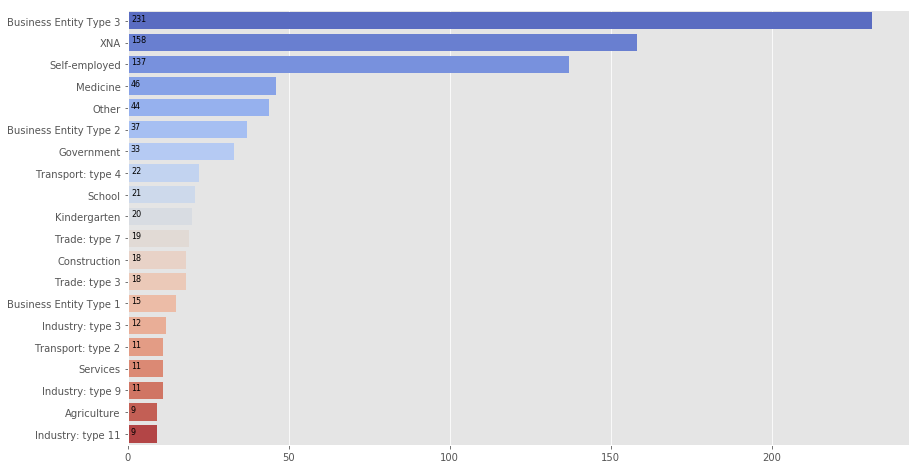

In [183]:
plt.figure(figsize=(14,8))
tmp = app_train['ORGANIZATION_TYPE'].value_counts()[:20]
sns.barplot(tmp.values, tmp.index, palette='coolwarm')
for i,v in enumerate(tmp.values):
    plt.text(1,i,v,fontsize=8,color='k')

### 2.24 Ext source

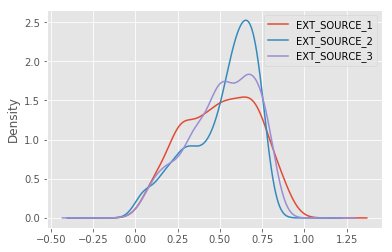

In [184]:
app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].plot(kind='kde')

### 2.25 Average house area 

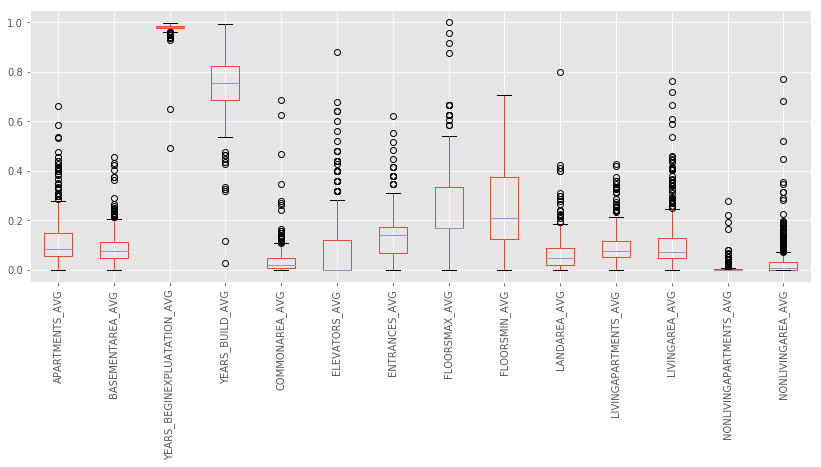

In [185]:
(app_train[['APARTMENTS_AVG','BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG', 
           'COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']]
.plot(kind='box',figsize=(14,5)))
plt.xticks(rotation=90);

In [186]:
gc.collect()

9039

## 3.0 Application train & application test data preprocessing
### 3.1 Merge application train and application test

In [187]:
#app_train['is_train'] = 'Yes'
#app_test['is_train'] = 'No'
train_test = pd.concat([app_train,app_test],axis=0,sort=False)
print('Number of rows and columns in train dataset: ',app_train.shape)
print('Number of rows and columns in test dataset: ',app_test.shape)
print('Number of rows and columns in train + test dataset: ',train_test.shape)
gc.collect()

Number of rows and columns in train dataset:  (1000, 122)
Number of rows and columns in test dataset:  (1000, 121)
Number of rows and columns in train + test dataset:  (2000, 122)


7

### 3.2 Column type segregation

In [188]:
cat_object_col = train_test.select_dtypes(exclude=['int','float']).columns # object
int_col = train_test.select_dtypes(include='int').columns
float_col = train_test.select_dtypes(include='float').columns

# int type
cat_int_col = train_test[int_col].columns[(train_test[int_col].nunique()<50).values]
remaining_int_col = [c for c in int_col if c not in cat_int_col]

# float type
cat_float_col = train_test[float_col].columns[(train_test[float_col].nunique()<50).values]
remaining_float_col = [c for c in float_col if c not in cat_float_col]

# verify number of columns
len(list(cat_object_col)+  list(cat_int_col)+ list(remaining_int_col)+ list(float_col)), train_test.shape[1]

float_col = float_col.drop('TARGET') # Our dependent variable
cat_float_col = cat_float_col.drop('TARGET') # Our dependent variable
#cat_object_col = cat_object_col.drop('is_train') # Our dependent variable
gc.collect()

21

### 3.3 Basic details

In [189]:
# Check basic details
basic_details(train_test[cat_object_col])

,missing_value,%missing_value,dtypes,N unique
NAME_CONTRACT_TYPE,0,0.00,object,2
CODE_GENDER,0,0.00,object,2
FLAG_OWN_CAR,0,0.00,object,2
FLAG_OWN_REALTY,0,0.00,object,2
NAME_TYPE_SUITE,18,0.90,object,7
NAME_INCOME_TYPE,0,0.00,object,4
NAME_EDUCATION_TYPE,0,0.00,object,4
NAME_FAMILY_STATUS,0,0.00,object,5
NAME_HOUSING_TYPE,0,0.00,object,6
OCCUPATION_TYPE,604,30.20,object,18


In [190]:
# Check missing value
basic_details(train_test[cat_int_col])

,missing_value,%missing_value,dtypes,N unique
CNT_CHILDREN,0,0.0,int64,6
FLAG_MOBIL,0,0.0,int64,1
FLAG_EMP_PHONE,0,0.0,int64,2
FLAG_WORK_PHONE,0,0.0,int64,2
FLAG_CONT_MOBILE,0,0.0,int64,2
FLAG_PHONE,0,0.0,int64,2
FLAG_EMAIL,0,0.0,int64,2
REGION_RATING_CLIENT,0,0.0,int64,3
REGION_RATING_CLIENT_W_CITY,0,0.0,int64,3
HOUR_APPR_PROCESS_START,0,0.0,int64,23


In [191]:
# Check missing value
basic_details(train_test[remaining_int_col])

,missing_value,%missing_value,dtypes,N unique
SK_ID_CURR,0,0.0,int64,2000
DAYS_BIRTH,0,0.0,int64,1875
DAYS_EMPLOYED,0,0.0,int64,1403
DAYS_ID_PUBLISH,0,0.0,int64,1651


In [192]:
# Check missing value
basic_details(train_test[cat_float_col])

,missing_value,%missing_value,dtypes,N unique
OWN_CAR_AGE,1315,65.75,float64,39
CNT_FAM_MEMBERS,0,0.00,float64,7
ELEVATORS_AVG,1045,52.25,float64,45
ENTRANCES_AVG,979,48.95,float64,49
FLOORSMIN_AVG,1370,68.50,float64,47
NONLIVINGAPARTMENTS_AVG,1393,69.65,float64,37
ELEVATORS_MODE,1045,52.25,float64,22
ENTRANCES_MODE,979,48.95,float64,20
FLOORSMAX_MODE,964,48.20,float64,21
FLOORSMIN_MODE,1370,68.50,float64,17


In [193]:
# Check missing value
basic_details(train_test[remaining_float_col])

,missing_value,%missing_value,dtypes,N unique
AMT_INCOME_TOTAL,0,0.00,float64,118
AMT_CREDIT,0,0.00,float64,779
AMT_ANNUITY,1,0.05,float64,1453
AMT_GOODS_PRICE,1,0.05,float64,240
REGION_POPULATION_RELATIVE,0,0.00,float64,78
DAYS_REGISTRATION,0,0.00,float64,1789
EXT_SOURCE_1,996,49.80,float64,1004
EXT_SOURCE_2,3,0.15,float64,1967
EXT_SOURCE_3,374,18.70,float64,473
APARTMENTS_AVG,994,49.70,float64,315


### 3.4 Fill missing value for Continues variables

In [194]:
# Replace 365243 with missing value
train_test['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)
# Fill missing value 
#missing_value_fill(app_train,cat_object_col,mean_or_mode='mode')
#missing_value_fill(app_train,cat_int_col,mean_or_mode='mode') 
#missing_value_fill(train_test,remaining_int_col,mean_or_mode='mean')
#missing_value_fill(train_test,remaining_float_col,mean_or_mode='mean')
#missing_value_fill(train_test,cat_float_col,mean_or_mode='mean')

### 3.5 One hot encoding for categorical columns

In [195]:
# Binary encoding
train_test = binary_encoding(train_test, cat_object_col)

train_test,_ = one_hot_encoding(train_test,cat_object_col)
train_test,_ = one_hot_encoding(train_test,cat_int_col)
train_test,_ = one_hot_encoding(train_test,cat_float_col)
#train_test,cat_cols = one_hot_encoder(train_test,nan_as_category=True)

gc.collect()

Original shape: (2000, 122)
After: (2000, 238)
Original shape (2000, 238)
After OHE (2000, 348)
Original shape (2000, 348)
After OHE (2000, 401)
Original shape (2000, 401)
After OHE (2000, 925)


91

In [196]:
del app_train,app_test
descriptive_stat_feat(train_test,remaining_float_col)
descriptive_stat_feat(train_test,remaining_int_col)

Before (2000, 925)


/home/sudhir/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


After  (2000, 1081)
Before (2000, 1081)
After  (2000, 1097)


In [ ]:
train_test['EXT_SOURCE_1']

In [230]:
## PolynomialFeatures
ploy_feat = PolynomialFeatures(degree=4,)
col = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
ploy_feat.fit_transform()

### 3.5 Reduce memory usage train_test dataset

In [197]:
reduce_memory_usage(train_test)
gc.collect()

Intial memory usage: 4.2438507080078125 MB
Memory usage after complition:  2.3517608642578125 MB


7

## 4 Bureau Balance and Bureau dataset
### 4.1 Glimpse Bureau balance dataset

In [198]:
print('Number of rows and columns in bureau dataset: ',bureau_balance.shape)
bureau_balance.head()

Number of rows and columns in bureau dataset:  (1000, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


### 4.2 Glimpse Bureau dataset

In [199]:
print('Number of rows and columns in bureau dataset: ',bureau.shape)
bureau.head()

Number of rows and columns in bureau dataset:  (1000, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [200]:
basic_details(bureau)

,missing_value,%missing_value,dtypes,N unique
SK_ID_CURR,0,0.0,int64,205
SK_ID_BUREAU,0,0.0,int64,1000
CREDIT_ACTIVE,0,0.0,object,3
CREDIT_CURRENCY,0,0.0,object,1
DAYS_CREDIT,0,0.0,int64,818
CREDIT_DAY_OVERDUE,0,0.0,int64,4
DAYS_CREDIT_ENDDATE,66,6.6,float64,796
DAYS_ENDDATE_FACT,356,35.6,float64,538
AMT_CREDIT_MAX_OVERDUE,593,59.3,float64,100
CNT_CREDIT_PROLONG,0,0.0,int64,3


In [201]:
cat_col = ['CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE']
float_col = bureau.select_dtypes(include='float').columns.values
int_col = ['DAYS_CREDIT','CREDIT_DAY_OVERDUE','DAYS_CREDIT_UPDATE','CNT_CREDIT_PROLONG'] 

###  4.3 one hot encoding

In [202]:
### one hot encoding
bureau_balance,bb_cat = one_hot_encoder(bureau_balance,nan_as_category=True)
bureau,bureau_cat = one_hot_encoder(bureau,nan_as_category=True)

# aggregation burea balance
bb_agregations = {'MONTHS_BALANCE':['min','max','size']}
for col in bb_cat:
    bb_agregations[col] =['mean']

# Aggregate on sk_id
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_agregations)
bb_agg.columns = pd.Index([e[0] +'_' +e[1].upper() for e in bb_agg.columns.tolist()])

# join bb_agg
bureau = bureau.join(bb_agg,how='left',on ='SK_ID_BUREAU')
bureau.drop('SK_ID_BUREAU',axis = 1,inplace=True)

In [203]:
# bureau and bureau_balance numeric feature
num_aggregators = {
    'DAYS_CREDIT': ['min','max','var'],
    'DAYS_CREDIT_ENDDATE': ['min','max','mean'],
    'DAYS_ENDDATE_FACT': ['mean'],
    'CREDIT_DAY_OVERDUE':['max','mean'],
    'AMT_CREDIT_SUM':['mean','sum'],
    'AMT_CREDIT_SUM_DEBT':['sum','max','mean'],
    'AMT_CREDIT_SUM_LIMIT':['sum','mean'],
    'AMT_CREDIT_SUM_OVERDUE':['mean'],
    'AMT_ANNUITY':['mean','max'],
    'CNT_CREDIT_PROLONG':['sum'],
    'MONTHS_BALANCE_MIN':['min'],
    'MONTHS_BALANCE_MAX':['max'],
    'MONTHS_BALANCE_SIZE':['size']
}

#bureau and bueau_balance categorical feature
cat_aggregates = {}
for col in bureau_cat:
    cat_aggregates[col] = ['mean']
for col in bb_cat:
    cat_aggregates[col+'_MEAN'] = ['mean']

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregators, **cat_aggregates})
bureau_agg.columns = pd.Index(['Bure_'+e[0]+'_'+e[1].upper() for e in bureau_agg.columns.tolist()])

# Bureau active credict using numerical columns
#active = bureau['CREDIT_ACTIVE_Closed']
del bureau,bureau_balance,bb_agg
gc.collect()
bureau_agg.head()

,Bure_DAYS_CREDIT_MIN,Bure_DAYS_CREDIT_MAX,Bure_DAYS_CREDIT_VAR,Bure_DAYS_CREDIT_ENDDATE_MIN,Bure_DAYS_CREDIT_ENDDATE_MAX,Bure_DAYS_CREDIT_ENDDATE_MEAN,Bure_DAYS_ENDDATE_FACT_MEAN,Bure_CREDIT_DAY_OVERDUE_MAX,Bure_CREDIT_DAY_OVERDUE_MEAN,Bure_AMT_CREDIT_SUM_MEAN,...,Bure_CREDIT_TYPE_Credit card_MEAN,Bure_CREDIT_TYPE_Microloan_MEAN,Bure_CREDIT_TYPE_Mortgage_MEAN,Bure_CREDIT_TYPE_nan_MEAN,Bure_STATUS_0_MEAN_MEAN,Bure_STATUS_1_MEAN_MEAN,Bure_STATUS_2_MEAN_MEAN,Bure_STATUS_C_MEAN_MEAN,Bure_STATUS_X_MEAN_MEAN,Bure_STATUS_nan_MEAN_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
101060,-2632,-709,779007.000000,-2478.0,783.0,-522.5,-1721.500000,0,0.0,204143.872500,...,0.250000,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
104261,-587,-587,NaN,872.0,872.0,872.0,NaN,0,0.0,450000.000000,...,0.000000,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
115001,-2784,-174,745005.410714,-2387.0,3198.0,-57.0,-766.666667,0,0.0,211705.987500,...,0.125000,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
118247,-2022,-484,333125.904762,-1838.0,-182.0,-1092.0,-1081.600000,0,0.0,78400.253571,...,0.571429,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
119306,-1040,-243,158816.333333,-917.0,1090.0,207.0,-629.000000,0,0.0,96765.000000,...,0.333333,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
reduce_memory_usage(bureau_agg)

Intial memory usage: 0.060214996337890625 MB
Memory usage after complition:  0.028934478759765625 MB


## 5.0 installments_payments

In [205]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [206]:
basic_details(installments_payments)

,missing_value,%missing_value,dtypes,N unique
SK_ID_PREV,0,0.0,int64,970
SK_ID_CURR,0,0.0,int64,965
NUM_INSTALMENT_VERSION,0,0.0,float64,10
NUM_INSTALMENT_NUMBER,0,0.0,int64,109
DAYS_INSTALMENT,0,0.0,float64,796
DAYS_ENTRY_PAYMENT,0,0.0,float64,818
AMT_INSTALMENT,0,0.0,float64,907
AMT_PAYMENT,0,0.0,float64,902


The dataset does not contain missing value, all variables as interge or float type, so one hot encoding is not required.

In [207]:
inst_num_aggregator = {
    'NUM_INSTALMENT_VERSION':['mean'],
    'NUM_INSTALMENT_NUMBER':['mean','max'],
    'DAYS_INSTALMENT':['min','mean'],
    'DAYS_ENTRY_PAYMENT':['min','mean'],
    'AMT_INSTALMENT':['mean'],
    'AMT_PAYMENT':['mean']
}

inst_agg = installments_payments.groupby('SK_ID_CURR').agg(inst_num_aggregator)
inst_agg.columns = pd.Index(['INST_'+e[0]+ '_'+ e[1].upper() for e in inst_agg.columns.tolist()])
del installments_payments
inst_agg.head()

,INST_NUM_INSTALMENT_VERSION_MEAN,INST_NUM_INSTALMENT_NUMBER_MEAN,INST_NUM_INSTALMENT_NUMBER_MAX,INST_DAYS_INSTALMENT_MIN,INST_DAYS_INSTALMENT_MEAN,INST_DAYS_ENTRY_PAYMENT_MIN,INST_DAYS_ENTRY_PAYMENT_MEAN,INST_AMT_INSTALMENT_MEAN,INST_AMT_PAYMENT_MEAN
SK_ID_CURR,,,,,,,,,
100012,3.0,4.0,4,-387.0,-387.0,-428.0,-428.0,5242.860,5242.860
100187,1.0,24.0,24,-1070.0,-1070.0,-1071.0,-1071.0,10281.870,10281.870
100193,0.0,56.0,56,-1153.0,-1153.0,-1153.0,-1153.0,301.860,301.860
100266,0.0,42.0,42,-58.0,-58.0,-58.0,-58.0,3.825,3.825
100299,1.0,2.0,2,-2323.0,-2323.0,-2293.0,-2293.0,15737.985,0.045


### 6.0 POS CASH balance

In [208]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [209]:
basic_details(POS_CASH_balance)

,missing_value,%missing_value,dtypes,N unique
SK_ID_PREV,0,0.0,int64,989
SK_ID_CURR,0,0.0,int64,989
MONTHS_BALANCE,0,0.0,int64,41
CNT_INSTALMENT,2,0.2,float64,27
CNT_INSTALMENT_FUTURE,2,0.2,float64,46
NAME_CONTRACT_STATUS,0,0.0,object,3
SK_DPD,0,0.0,int64,11
SK_DPD_DEF,0,0.0,int64,10


In [210]:
## One hot encoding
POS_CASH_balance,pos_cat = one_hot_encoding(POS_CASH_balance,columns=['NAME_CONTRACT_STATUS'])
pos_aggregate ={
    'MONTHS_BALANCE':['mean','max'],
    'CNT_INSTALMENT':['mean'],
    'CNT_INSTALMENT_FUTURE':['mean'],
    'SK_DPD':['max','mean'],
    'SK_DPD_DEF':['max','mean']
}
for col in pos_cat:
    pos_aggregate[col] =['mean']
pos_agg = POS_CASH_balance.groupby('SK_ID_CURR').agg(pos_aggregate)
pos_agg.columns = pd.Index(['POS_'+ e[0]+ '_'+ e[1].upper() for e in pos_agg.columns.tolist()])
del POS_CASH_balance
pos_agg.head()

Original shape (1000, 8)
After OHE (1000, 10)


,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN
SK_ID_CURR,,,,,,,,,,,
100187,-43.0,-43,24.0,8.0,0,0,0,0,0.0,0,0
100457,-16.0,-16,24.0,23.0,0,0,0,0,0.0,0,0
100676,-41.0,-41,24.0,12.0,0,0,0,0,0.0,0,0
101741,-33.0,-33,24.0,8.0,0,0,0,0,0.0,0,0
102489,-18.0,-18,24.0,22.0,0,0,0,0,0.0,0,0


In [211]:
reduce_memory_usage(pos_agg)

Intial memory usage: 0.07734107971191406 MB
Memory usage after complition:  0.02923870086669922 MB


## 7.0 credit_card_balance

In [212]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [213]:
basic_details(credit_card_balance)

,missing_value,%missing_value,dtypes,N unique
SK_ID_PREV,0,0.0,int64,1000
SK_ID_CURR,0,0.0,int64,1000
MONTHS_BALANCE,0,0.0,int64,7
AMT_BALANCE,0,0.0,float64,622
AMT_CREDIT_LIMIT_ACTUAL,0,0.0,int64,35
AMT_DRAWINGS_ATM_CURRENT,137,13.7,float64,54
AMT_DRAWINGS_CURRENT,0,0.0,float64,343
AMT_DRAWINGS_OTHER_CURRENT,137,13.7,float64,4
AMT_DRAWINGS_POS_CURRENT,137,13.7,float64,307
AMT_INST_MIN_REGULARITY,0,0.0,float64,506


In [214]:
## One hot encoding
credit_card_balance,credit_cat = one_hot_encoder(credit_card_balance)
# General aggregation
credit_card_balance.drop('SK_ID_PREV',axis=1,inplace=True)
credit_agg = credit_card_balance.groupby('SK_ID_CURR').agg(['min','max','mean','sum','var'])
credit_agg.columns = pd.Index(['CREDIT_'+e[0]+'_'+ e[1] for e in credit_agg.columns.tolist()])
del credit_card_balance
credit_agg.head()

,CREDIT_MONTHS_BALANCE_min,CREDIT_MONTHS_BALANCE_max,CREDIT_MONTHS_BALANCE_mean,CREDIT_MONTHS_BALANCE_sum,CREDIT_MONTHS_BALANCE_var,CREDIT_AMT_BALANCE_min,CREDIT_AMT_BALANCE_max,CREDIT_AMT_BALANCE_mean,CREDIT_AMT_BALANCE_sum,CREDIT_AMT_BALANCE_var,...,CREDIT_NAME_CONTRACT_STATUS_Completed_min,CREDIT_NAME_CONTRACT_STATUS_Completed_max,CREDIT_NAME_CONTRACT_STATUS_Completed_mean,CREDIT_NAME_CONTRACT_STATUS_Completed_sum,CREDIT_NAME_CONTRACT_STATUS_Completed_var,CREDIT_NAME_CONTRACT_STATUS_nan_min,CREDIT_NAME_CONTRACT_STATUS_nan_max,CREDIT_NAME_CONTRACT_STATUS_nan_mean,CREDIT_NAME_CONTRACT_STATUS_nan_sum,CREDIT_NAME_CONTRACT_STATUS_nan_var
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100218,-4,-4,-4,-4,NaN,748180.935,748180.935,748180.935,748180.935,NaN,...,0,0,0,0,NaN,0,0,0,0,NaN
100662,-5,-5,-5,-5,NaN,0.000,0.000,0.000,0.000,NaN,...,0,0,0,0,NaN,0,0,0,0,NaN
100796,-4,-4,-4,-4,NaN,0.000,0.000,0.000,0.000,NaN,...,0,0,0,0,NaN,0,0,0,0,NaN
101399,-7,-7,-7,-7,NaN,410062.365,410062.365,410062.365,410062.365,NaN,...,0,0,0,0,NaN,0,0,0,0,NaN
101827,-6,-6,-6,-6,NaN,0.000,0.000,0.000,0.000,NaN,...,0,0,0,0,NaN,0,0,0,0,NaN


## previous_application

In [215]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
cat_col = previous_application.select_dtypes(include='object').columns
int_col = [i for i in previous_application.columns.values if i not in cat_col]

In [217]:
basic_details(previous_application[cat_col])

,missing_value,%missing_value,dtypes,N unique
NAME_CONTRACT_TYPE,0,0.0,object,3
WEEKDAY_APPR_PROCESS_START,0,0.0,object,7
FLAG_LAST_APPL_PER_CONTRACT,0,0.0,object,2
NAME_CASH_LOAN_PURPOSE,0,0.0,object,12
NAME_CONTRACT_STATUS,0,0.0,object,4
NAME_PAYMENT_TYPE,0,0.0,object,4
CODE_REJECT_REASON,0,0.0,object,7
NAME_TYPE_SUITE,497,49.7,object,7
NAME_CLIENT_TYPE,0,0.0,object,4
NAME_GOODS_CATEGORY,0,0.0,object,20


In [218]:
basic_details(previous_application[int_col])

,missing_value,%missing_value,dtypes,N unique
SK_ID_PREV,0,0.0,int64,1000
SK_ID_CURR,0,0.0,int64,985
AMT_ANNUITY,198,19.8,float64,738
AMT_APPLICATION,0,0.0,float64,577
AMT_CREDIT,0,0.0,float64,698
AMT_DOWN_PAYMENT,438,43.8,float64,228
AMT_GOODS_PRICE,193,19.3,float64,577
HOUR_APPR_PROCESS_START,0,0.0,int64,20
NFLAG_LAST_APPL_IN_DAY,0,0.0,int64,2
RATE_DOWN_PAYMENT,438,43.8,float64,252


In [219]:
## Fill missing value
previous_application['DAYS_FIRST_DRAWING'].replace({365243:np.nan},inplace=True)
previous_application['DAYS_FIRST_DUE'].replace({365243:np.nan},inplace=True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace({365243:np.nan},inplace=True)
previous_application['DAYS_LAST_DUE'].replace({365243:np.nan},inplace=True)
previous_application['DAYS_TERMINATION'].replace({365243:np.nan},inplace=True)


In [220]:
# One hot encoding
previous_application,prev_cat_col = one_hot_encoding(previous_application,columns= cat_col)

prev_aggregate = {
    'AMT_ANNUITY':['mean','sum','min'],
    'AMT_APPLICATION':['mean'],
    'AMT_CREDIT':['mean','min','max'],
    'AMT_DOWN_PAYMENT':['mean','min'],
    'AMT_GOODS_PRICE':['mean','sum','max'],
    'HOUR_APPR_PROCESS_START':['mean','min'],
     'NFLAG_LAST_APPL_IN_DAY': ['mean'],
     'RATE_DOWN_PAYMENT': ['mean'],
     'RATE_INTEREST_PRIMARY':['mean','min','max'],
     'RATE_INTEREST_PRIVILEGED':['mean','min'],
     'DAYS_DECISION':['mean'],
     'SELLERPLACE_AREA':['mean'],
     'CNT_PAYMENT':['mean','sum'],
     'DAYS_FIRST_DRAWING':['mean','min'],
     'DAYS_FIRST_DUE':['mean','min'],
     'DAYS_LAST_DUE_1ST_VERSION':['mean','min'],
     'DAYS_LAST_DUE':['mean','max'],
     'DAYS_TERMINATION':['mean','max'],
     'NFLAG_INSURED_ON_APPROVAL' : ['mean'],
}

prev_cat_aggregate = {}
for col in prev_cat_col:
    prev_cat_aggregate[col] =['mean']
prev_agg = previous_application.groupby('SK_ID_CURR').agg({**prev_aggregate, **prev_cat_aggregate})
prev_agg.columns = pd.Index(['PREV_'+e[0]+ '_'+ e[1].upper() for e in prev_agg.columns.tolist()])
del previous_application
prev_agg.head()

Original shape (1000, 37)
After OHE (1000, 136)


,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_SUM,PREV_AMT_ANNUITY_MIN,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_GOODS_PRICE_MEAN,...,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100077,NaN,0.000,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
100373,10872.990,10872.990,10872.990,115695.0,115119.0,115119.0,115119.0,11569.5,11569.5,115695.0,...,0.0,0.0,1,0,0,0,0,0,0,0
101011,6856.065,6856.065,6856.065,65866.5,66735.0,66735.0,66735.0,6588.0,6588.0,65866.5,...,0.0,0.0,1,0,0,0,0,0,0,0
101167,5437.530,5437.530,5437.530,120060.0,120060.0,120060.0,120060.0,0.0,0.0,120060.0,...,0.0,0.0,0,1,0,0,0,0,0,0
101211,4172.940,4172.940,4172.940,29205.0,21204.0,21204.0,21204.0,9000.0,9000.0,29205.0,...,0.0,0.0,1,0,0,0,0,0,0,0


### Join

In [221]:
# Join all aggregated df with train_test
train_test = train_test.join(bureau_agg,how='left',on='SK_ID_CURR') # bureau
del bureau_agg
train_test = train_test.join(pos_agg, how='left',on='SK_ID_CURR') # POS_CASH
del pos_agg
train_test = train_test.join(inst_agg,how='left',on='SK_ID_CURR') # install
del inst_agg
train_test = train_test.join(credit_agg, how='left',on='SK_ID_CURR') # credit card
del credit_agg
train_test = train_test.join(prev_agg, how='left',on='SK_ID_CURR') # previous
del prev_agg
reduce_memory_usage(train_test)

Intial memory usage: 7.0667266845703125 MB
Memory usage after complition:  4.8465728759765625 MB


## Model selection

In [222]:
# Select columns whose variance > 0
col = train_test.columns
feat = train_test.columns[train_test.var() >0]
train_test = train_test[feat]
len(feat) - len(col)

-316

In [223]:
#from sklearn.model_selection import train_test_split
col_drop = ['TARGET','SK_ID_CURR']
X = train_test[train_test['TARGET'].notnull()].drop(col_drop, axis=1)
y = train_test[train_test['TARGET'].notnull()]['TARGET']
test_new = train_test[train_test['TARGET'].isnull()].drop(col_drop, axis=1)

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=seed)

## Model building

In [224]:
# Lightgbm

def model(X_train, X_valid, y_train, y_valid,test_new,random_seed):
    
    lg_param = {}
    lg_param['learning_rate'] = 0.02
    lg_param['n_estimators'] = 10000
    lg_param['max_depth'] = 8
    lg_param['num_leaves'] = 34
    lg_param['boosting_type'] = 'gbdt'
    lg_param['feature_fraction'] = 0.9
    lg_param['bagging_fraction'] = 0.9
    lg_param['min_child_samples'] = 30
    lg_param['lambda_l1'] = 0.04
    lg_param['lambda_l2'] = 0.08
    lg_param['silent'] = -1
    lg_param['verbose'] = -1
    lg_param['nthread'] = 4
    lg_param['seed'] = random_seed
    
    lgb_model = lgb.LGBMClassifier(**lg_param)
    print('-'*10,'*'*20,'-'*10)
    lgb_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_valid,y_valid)], 
                 eval_metric ='auc', verbose =100, early_stopping_rounds=200)
    y_pred = lgb_model.predict_proba(X_valid)[:,1]
    print('roc_auc_score',roc_auc_score(y_valid,y_pred),'-'*30,i+1)
    y_pred_new = lgb_model.predict_proba(test_new)[:,1]
    return y_pred,y_pred_new,lgb_model

In [225]:
# KFold cross validation
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

#y_pred = 0
y_pred_new = 0

for i,(train_index, valid_index) in enumerate(kf.split(X,y)):    
    X_train, X_valid = X.loc[train_index], X.loc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print('\n{} fold of {} KFold'.format(i+1,kf.n_splits))
    y_pred,y_pred2,lgb_model = model(X_train, X_valid, y_train, y_valid,test_new,random_seed = i)
    #y_pred += y_pred1
    y_pred_new += y_pred2



1 fold of 3 KFold
---------- ******************** ----------
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.997045	valid_1's auc: 0.667197
[200]	training's auc: 1	valid_1's auc: 0.654618
Early stopping, best iteration is:
[2]	training's auc: 0.896071	valid_1's auc: 0.742038
roc_auc_score 0.7420382165605096 ------------------------------ 1

2 fold of 3 KFold
---------- ******************** ----------
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.996254	valid_1's auc: 0.719391
[200]	training's auc: 0.999965	valid_1's auc: 0.712244
Early stopping, best iteration is:
[53]	training's auc: 0.979836	valid_1's auc: 0.732875
roc_auc_score 0.7328748651564185 ------------------------------ 2

3 fold of 3 KFold
---------- ******************** ----------
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.998577	valid_1's auc: 0.732774
[200]	training's auc: 1	valid_1's auc: 0.744425


Text(0.5,1,'Reciver Operating Characteristics')

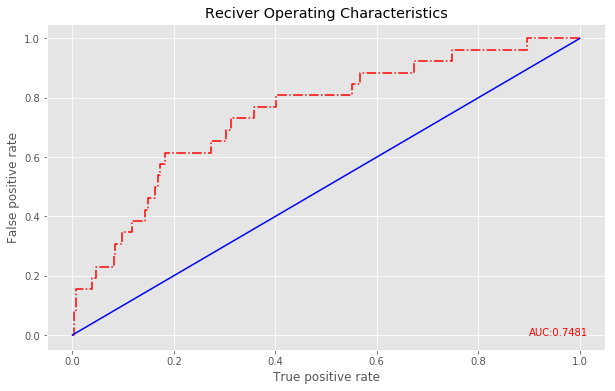

In [229]:
fpr,tpr,threshold =roc_curve(y_valid, y_pred)
plt.figure(figsize= (10,6))
auc_value = round(auc(fpr,tpr),4)
plt.text(0.9,0,'AUC:'+str(auc_value),color='r')
plt.plot(fpr,tpr, 'r-.',label='roc')
plt.plot([0,1],[0,1],'b-')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciver Operating Characteristics')

### Submision

In [227]:
submit  = pd.DataFrame({'SK_ID_CURR':test_index,'TARGET':y_pred_new/kf.n_splits})
submit.to_csv('home_credit.csv',index=False)
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.040622
1,100005,0.058524
2,100013,0.038428
3,100028,0.042772
4,100038,0.061664
